# RNN архитектура нейронных сетей на PyTorch

In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
import numpy as np
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("Electric_Production.csv")
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
IPG2211A2N,397.0,88.847218,15.387834,55.3151,77.1052,89.7795,100.5244,129.4048


### Нормализация временного ряда

In [5]:
df['DATE'] = pd.to_datetime(df['DATE'])

numerical_columns = df.select_dtypes(include=["float"]).columns

minmax_scaler = MinMaxScaler()
df[numerical_columns] = minmax_scaler.fit_transform(df[numerical_columns])

### Визуализация временных рядов

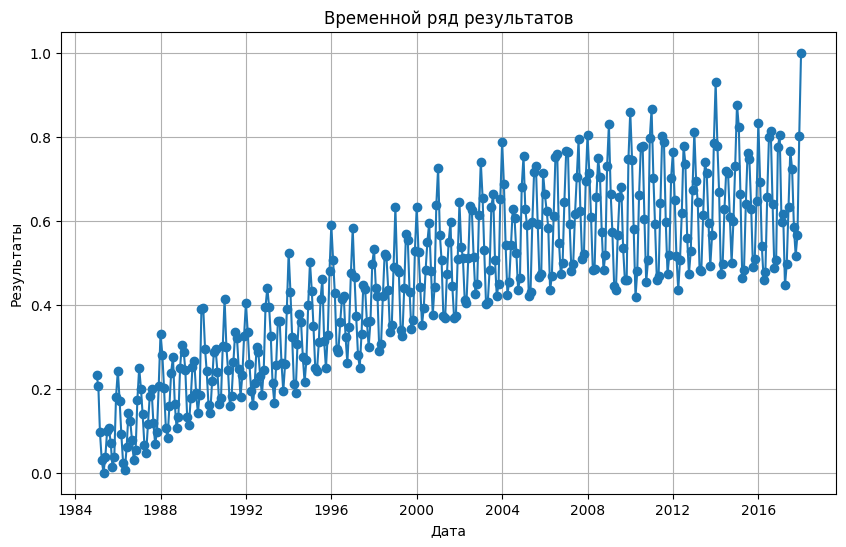

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(df['DATE'], df['IPG2211A2N'], marker='o', linestyle='-')
plt.title('Временной ряд результатов')
plt.xlabel('Дата')
plt.ylabel('Результаты')
plt.grid(True)
plt.show()

### Создание тренировочного и тестового датасетов

In [15]:
df['DATE'] = pd.to_datetime(df['DATE'])
df['DATE'] = df['DATE'].apply(lambda x: x.toordinal())

X = df['DATE'].values 
y = df['IPG2211A2N'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = torch.tensor(X_train[:, np.newaxis], dtype=torch.float32)
X_test = torch.tensor(X_test[:, np.newaxis], dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

### Создание RNN модели

In [16]:
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=64, batch_first=True)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc1(x[:, -1, :])
        x = torch.relu(x)
        x = self.fc2(x)
        return torch.tanh(x)
    
rnn_model = RNNModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0 
    for inputs, labels in train_loader:
        inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def evaluate(model, test_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
    return val_loss / len(test_loader)

num_epochs = 100
patience = 5
best_loss = float("inf")
counter = 0
for epoch in range(num_epochs):
    train_loss = train(rnn_model, train_loader, criterion, optimizer)
    val_loss = evaluate(rnn_model, test_loader, criterion)
    
    print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = rnn_model.state_dict().copy()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break 

rnn_model.load_state_dict(best_model_wts)

rnn_model.eval()
y_pred = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.unsqueeze(1)
        outputs = rnn_model(inputs)
        y_pred.extend(outputs.squeeze().numpy())
        
y_pred = np.array(y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

Epoch 1, Loss: 0.1068, Val Loss: 0.1115
Epoch 2, Loss: 0.0690, Val Loss: 0.0473
Epoch 3, Loss: 0.0483, Val Loss: 0.0483
Epoch 4, Loss: 0.0439, Val Loss: 0.0546
Epoch 5, Loss: 0.0435, Val Loss: 0.0472
Epoch 6, Loss: 0.0421, Val Loss: 0.0492
Epoch 7, Loss: 0.0425, Val Loss: 0.0477
Epoch 8, Loss: 0.0420, Val Loss: 0.0489
Epoch 9, Loss: 0.0422, Val Loss: 0.0477
Epoch 10, Loss: 0.0421, Val Loss: 0.0476
Early stopping
RMSE: 0.21937236


### LSTM модель

In [17]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc1(x[:, -1, :])
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return torch.tanh(x)
    
lstm_model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def evaluate(model, test_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
    return val_loss / len(test_loader)

num_epochs = 100
patience = 5
best_loss = float("inf")
counter = 0
        
for epoch in range(num_epochs):
    train_loss = train(lstm_model, train_loader, criterion, optimizer)
    test_loss = evaluate(lstm_model, test_loader, criterion)
    
    print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    if val_loss < best_loss:
        val_loss = best_loss
        best_model_wts = lstm_model.state_dict().copy()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break
            
lstm_model.load_state_dict(best_model_wts)

lstm_model.eval()
y_pred = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.unsqueeze(1)
        outputs = lstm_model(inputs)
        y_pred.extend(outputs.squeeze().numpy())
        
y_pred = np.array(y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

Epoch 1, Loss: 0.0597, Val Loss: 0.0476
Epoch 2, Loss: 0.0489, Val Loss: inf
Epoch 3, Loss: 0.0444, Val Loss: inf
Epoch 4, Loss: 0.0435, Val Loss: inf
Epoch 5, Loss: 0.0430, Val Loss: inf
Epoch 6, Loss: 0.0447, Val Loss: inf
Early stopping
RMSE: 0.21991353
